In [1]:
import tensorflow as tf
from keras.datasets import cifar100
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, Activation, Lambda, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import datetime, os
import time
import pandas as pd
import seaborn as sns

%load_ext tensorboard

In [2]:
#Load dataset
(X_c_train, y_c_train), (X_c_test, y_c_test) = cifar100.load_data(label_mode='coarse')
(X_f_train, y_f_train), (X_f_test, y_f_test) = cifar100.load_data(label_mode='fine')

#######################
# Clusters are obtained from:
# https://github.com/stephenyan1231/caffe-public/blob/hdcnn/examples/cifar100/hdcnn/python/cifar100_NIN_raw.ipynb
# Mapping fine -> cluster
mapping_fine_to_cluster = {0: 5,1: 2,2: 3,3: 6,4: 6,5: 0,6: 2,7: 2,8: 8,9: 1,10:1,11:3,12:8,13:8,14:2,15:6,16:1,17:8,18:2,19:6,20:0,21:3,22:1,23:7,24:2,25:0,26:2,27:6,28:1,29:6,30:6,31:6,32:6,33:4,34:6,35:3,36:6,37:8,38:6,39:1,40:1,41:8,42:6,43:6,44:2,45:2,46:3,47:4,48:8,49:7,50:6,51:5,52:4,53:5,54:5,55:6,56:4,57:5,58:8,59:4,60:7,61:1,62:5,63:6,64:6,65:6,66:6,67:6,68:7,69:1,70:5,71:7,72:6,73:2,74:6,75:6,76:1,77:2,78:2,79:2,80:6,81:8,82:2,83:5,84:0,85:8,86:1,87:0,88:6,89:8,90:8,91:2,92:5,93:6,94:0,95:6,96:4,97:6,98:3,99:2}
def map_fine_to_cluster(y_f):
  y_cluster = []
  for f in  y_f:
    k = f[0]
    c = np.array([mapping_fine_to_cluster[k]])
    y_cluster.append(c)
  return np.array(y_cluster)
  
y_c_train = map_fine_to_cluster(y_f_train)
y_c_test = map_fine_to_cluster(y_f_test)
########################


X_train = X_f_train
X_val = X_f_test[:5000]
X_test = X_f_test[5000:]

y_train = [y_c_train, y_f_train]
y_val = [y_c_test[:5000], y_f_test[:5000]]
y_test = [y_c_test[5000:], y_f_test[5000:]]

image_size = X_train[0].shape

num_classes_c = len(set([v[0] for v in y_c_train]))
num_classes_f = len(set([v[0] for v in y_f_train]))

# Encode matrix M
M = [[0 for x in range(num_classes_f)] for y in range(num_classes_c)] 
for (c, f) in zip(y_c_train, y_f_train):
  c = c[0]
  f = f[0]
  M[c][f] = 1


In [3]:
class global_accuracy(keras.callbacks.Callback):
    """
    Each `SquadExample` object contains the character level offsets for each token
    in its input paragraph. We use them to get back the span of text corresponding
    to the tokens between our predicted start and end tokens.
    All the ground-truth answers are also present in each `SquadExample` object.
    We calculate the percentage of data points where the span of text obtained
    from model predictions matches one of the ground-truth answers.
    """

    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval

    def on_epoch_end(self, epoch, logs=None):
      accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(self.model, self.x_eval, self.y_eval)

      accuracy_ci = 1.96 * np.std(accuracy) / np.sqrt(len(accuracy))
      accuracy = np.mean(accuracy)
      
      accuracy_c_ci = 1.96 * np.std(accuracy_c) / np.sqrt(len(accuracy_c))
      accuracy_c = np.mean(accuracy_c)
      
      accuracy_f_ci = 1.96 * np.std(accuracy_f) / np.sqrt(len(accuracy_f))
      accuracy_f = np.mean(accuracy_f)

      accuracy_c_no_f = np.mean(accuracy_c_no_f)

      accuracy_f_no_c = np.mean(accuracy_f_no_c)

      accuracy_no_f_no_c = np.mean(accuracy_no_f_no_c)

      accuracy_consistency = np.mean(accuracy_consistency)

      consistency = np.mean(consistency)


      print('-'*100)
      print(f"epoch={epoch+1}, global accuracy = {accuracy:.4f}±{accuracy_ci:.4f}, accuracy_c = {accuracy_c:.4f}±{accuracy_c_ci:.4f}, accuracy_f = {accuracy_f:.4f}±{accuracy_f_ci:.4f}, accuracy_c_no_f = {accuracy_c_no_f:.4f}, accuracy_f_no_c = {accuracy_f_no_c:.4f}, accuracy_no_f_no_c = {accuracy_no_f_no_c:.4f}, accuracy_consistency = {accuracy_consistency:.4f}, consistency = {consistency:.4f}")
      print('-'*100)
      print('')

def get_metrics(model, X, y):
  pred_c, pred_f = model.predict(X)
  accuracy = []
  accuracy_c = []
  accuracy_c_no_f = []
  accuracy_f = []
  accuracy_f_no_c = []
  accuracy_no_f_no_c = []
  accuracy_consistency = []
  consistency = []
  for idx, (c, f) in enumerate(zip(pred_c, pred_f)):
    c = np.argmax(c)
    f = np.argmax(f)
    if M[c][f] == 1:
      consistency.append(1)
    else:
      consistency.append(0)

    if y[0][idx][0] == c and y[1][idx][0] == f:
      accuracy.append(1)
      accuracy_c.append(1)
      accuracy_f.append(1)
      accuracy_c_no_f.append(0)
      accuracy_f_no_c.append(0)
      accuracy_no_f_no_c.append(0)
      accuracy_consistency.append(1)
    elif y[0][idx][0] == c and y[1][idx][0] != f:
      accuracy.append(0)
      accuracy_c.append(1)
      accuracy_f.append(0)
      accuracy_c_no_f.append(1)
      accuracy_f_no_c.append(0)
      accuracy_no_f_no_c.append(0)
      if M[c][f] == 1:
        accuracy_consistency.append(1)
      else:
        accuracy_consistency.append(0)

    elif y[0][idx][0] != c and y[1][idx][0] == f:
      accuracy.append(0)
      accuracy_c.append(0)
      accuracy_f.append(1)
      accuracy_c_no_f.append(0)
      accuracy_f_no_c.append(1)
      accuracy_no_f_no_c.append(0)
      accuracy_consistency.append(0)
    else:
      accuracy.append(0)
      accuracy_c.append(0)
      accuracy_f.append(0)    
      accuracy_c_no_f.append(0)
      accuracy_f_no_c.append(0)
      accuracy_no_f_no_c.append(1)
      accuracy_consistency.append(0)
    # break
  
  return accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency



In [4]:
class Custom_Layer(keras.layers.Layer):
    def __init__(self, M, mode='both'):
        super(Custom_Layer, self).__init__()
        self.M = M
        if mode in ['both', 'c_to_f', 'f_to_c']:
          self.mode = mode

    def build(self, input_shape):
        """Creates scale variable if use_scale==True."""
        if isinstance(input_shape, list):
          input_dim1 = input_shape[0][1]
          input_dim2 = input_shape[0][1]
        else:
          input_dim1 = input_shape[1]
          input_dim2 = input_shape[1]
        
        units_c = len(self.M)
        units_f = len(self.M[0])
        self.M = tf.convert_to_tensor(self.M, dtype=tf.float32)

        self.W_c = self.add_weight(
            shape=(input_dim1, units_c), initializer="random_normal", trainable=True
        )
        self.b_c = self.add_weight(shape=(units_c,), initializer="zeros", trainable=True)
        self.W_f = self.add_weight(
            shape=(input_dim2, units_f), initializer="random_normal", trainable=True
        )
        self.b_f = self.add_weight(shape=(units_f,), initializer="zeros", trainable=True)

    def call(self, inputs):
      # Code the six equation
      if isinstance(inputs, list):
        inputs1 = inputs[0]
        inputs2 = inputs[1]
      else:
        inputs1 = inputs
        inputs2 = inputs
      
      z_c = tf.matmul(inputs1, self.W_c) + self.b_c # z^{(i)}_{c}= a^{[l]} \times W_{c} + b_{c}
      z_f = tf.matmul(inputs2, self.W_f) + self.b_f #  z^{(i)}_{f}= a^{[l]} \times  W_{f}+ b_{f}
      if self.mode == 'both' or self.mode == 'f_to_c':
        m_c = tf.matmul(tf.nn.softmax(z_f), tf.transpose(self.M)) # m^{(i)}_{c}= softmax(z^{(i)}_{f})\times M^{T}            
        y_c = tf.nn.softmax(z_c * m_c) # \hat{y}^{(i)}_{c}= softmax(z^{(i)}_{c}\circ m^{(i)}_{c})
      else:
        y_c = tf.nn.softmax(z_c)

      if self.mode == 'both' or self.mode == 'c_to_f':
        m_f = tf.matmul(tf.nn.softmax(z_c), self.M) #  m^{(i)}_{f}= softmax(z^{(i)}_{c})\times M
        y_f = tf.nn.softmax(z_f * m_f) # \hat{y}^{(i)}_{f}= softmax(z^{(i)}_{f}\circ m^{(i)}_{f})
      else:
        y_f = tf.nn.softmax(z_f)

      return y_c, y_f

    def get_config(self):
        config = {'M': self.M, 
                  'W_c': self.W_c,
                  'W_f': self.W_f,
                  'b_f': self.b_f,
                  'b_f': self.b_f}
        base_config = super(Custom_Layer, self).get_config()
        return base_config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [5]:
batch = 128
epochs = 50
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
global_accuracy_callback = global_accuracy(X_val, y_val)


In [6]:
def get_model1(learning_rate=1e-5, pi=0.5):
    # Conv base
    in_layer = Input(shape=image_size, name='main_input')
    conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")(in_layer)
    conv_base = Flatten()(conv_base)
    # coarse output
    out_c = Dense(num_classes_c, activation="softmax", name='out_c')(conv_base)
    # fine output 
    out_f = Dense(num_classes_f, activation="softmax", name='out_f')(conv_base)
    # Build the model
    model = Model(name='Model_1',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

# model = get_model1()
# model.summary()
# plot_model(model)

In [7]:
def get_model2(learning_rate=1e-5, pi=0.5):
    # Conv base
    in_layer = Input(shape=image_size, name='main_input')
    conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")(in_layer)
    conv_base = Flatten()(conv_base)
    # coarse output
    out_c = Dense(num_classes_c, activation="softmax", name='out_c')(conv_base)
    # fine output 
    out_f = Dense(num_classes_f, activation="softmax", name='out_f')(out_c)
    # Build the model
    model = Model(name='Model_2',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

# model = get_model2()
# model.summary()
# plot_model(model)

In [8]:
def get_model3(learning_rate=1e-5, pi=0.5):
    # Conv base
    in_layer = Input(shape=image_size, name='main_input')
    conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")(in_layer)
    conv_base = Flatten()(conv_base)    
    # fine output 
    out_f = Dense(num_classes_f, activation="softmax", name='out_f')(conv_base)
    # coarse output
    out_c = Dense(num_classes_c, activation="softmax", name='out_c')(out_f)
    # Build the model
    model = Model(name='Model_3',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

# model = get_model3()
# model.summary()
# plot_model(model)

In [9]:
def get_model4(learning_rate=1e-5, pi=0.5):
    # Conv base
    in_layer = Input(shape=image_size, name='main_input')
    conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")(in_layer)
    conv_base = Flatten()(conv_base)
    # coarse output
    logits_c = Dense(num_classes_c, name='logits_c')(conv_base)
    out_c = Activation(keras.activations.softmax, name='out_c')(logits_c)
    
    # fine output 
    relu_c = Activation(keras.activations.relu, name='relu_c')(logits_c)
    out_f = Dense(num_classes_f, activation="softmax", name='out_f')(relu_c)
    # Build the model
    model = Model(name='Model_4',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

# model = get_model4()
# model.summary()
# plot_model(model)


In [10]:
def get_model5(learning_rate=1e-5, pi=0.5):
    # Conv base
    in_layer = Input(shape=image_size, name='main_input')
    conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")(in_layer)
    conv_base = Flatten()(conv_base)
    # coarse output
    logits_f = Dense(num_classes_f, name='logits_f')(conv_base)
    relu_f = Activation(keras.activations.relu, name='relu_f')(logits_f)
    out_c = Dense(num_classes_c, activation="softmax", name='out_c')(relu_f)
    # fine output 
    out_f = Activation(keras.activations.softmax, name='out_f')(logits_f)
    # Build the model
    model = Model(name='Model_5',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

# model = get_model5()
# model.summary()
# plot_model(model)


In [11]:
def get_model6(learning_rate=1e-5, pi=0.5):
    # Conv base
    conv_base1 = keras.applications.VGG19(
    include_top=False,
    weights="imagenet")
    conv_base1._name = 'vgg19_1'
    conv_base2 = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")
    conv_base2._name = 'vgg19_2'
    in_layer = Input(shape=image_size, name='main_input')
    conv_base1 = conv_base1(in_layer)    
    conv_base1 = Flatten()(conv_base1)

    conv_base2 = conv_base2(in_layer)
    conv_base2 = Flatten()(conv_base2)
    # coarse output
    out_c = Dense(num_classes_c, activation="softmax", name='out_c')(conv_base1)
    # fine output 
    out_f = Dense(num_classes_f, activation="softmax", name='out_f')(conv_base2)
    # Build the model
    model = Model(name='Model_6',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

# model = get_model6()
# model.summary()
# plot_model(model)

In [12]:
def get_model7(learning_rate=1e-5, pi=0.5, mode='both'):
    # Conv base
    in_layer = Input(shape=image_size, name='main_input')
    conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")(in_layer)
    conv_base = Flatten()(conv_base)
    # outputs 
    out_c, out_f = Custom_Layer(M, mode)(conv_base)
    # Build the model
    model = Model(name='Model_7',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

# model = get_model7()
# model.summary()
# plot_model(model)


In [13]:
def get_model8(learning_rate=1e-5, pi=0.5, mode='both'):
    # Conv base
    conv_base1 = keras.applications.VGG19(
    include_top=False,
    weights="imagenet")
    conv_base1._name = 'vgg19_1'
    conv_base2 = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")
    conv_base2._name = 'vgg19_2'
    in_layer = Input(shape=image_size, name='main_input')
    conv_base1 = conv_base1(in_layer)    
    conv_base1 = Flatten()(conv_base1)

    conv_base2 = conv_base2(in_layer)
    conv_base2 = Flatten()(conv_base2)

    out_c, out_f = Custom_Layer(M, mode)([conv_base1, conv_base2])
    # Build the model
    model = Model(name='Model_8',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

# model = get_model8()
# model.summary()
# plot_model(model)

Model: "Model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten (Flatten)               (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
out_c (Dense)                   (None, 9)            4617        flatten[0][0]                    
____________________________________________________________________________________________

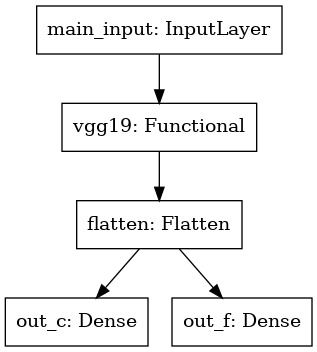

In [14]:
# Create the model
model1_pi1 = get_model1(pi=1)
model1_pi1.summary()
#train model
history_model1_pi1 = model1_pi1.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback]
                    )
plot_model(model1_pi1)



Model: "Model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
out_c (Dense)                   (None, 9)            4617        flatten_1[0][0]                  
____________________________________________________________________________________________

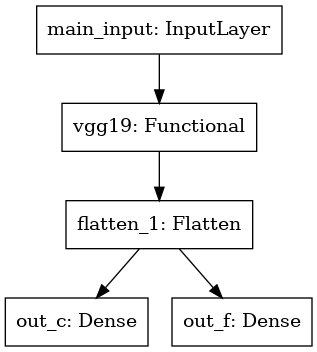

In [15]:
# Create the model
model1_pi0 = get_model1(pi=0)
model1_pi0.summary()
#train model
history_model1_pi0 = model1_pi0.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model1_pi0)



In [16]:
pred_c, _ = model1_pi0.predict(X_test)
_, pred_f = model1_pi1.predict(X_test)

accuracy_f = []
accuracy_c = []
consistency = []
consistency2 = []
consistency3 = []
for idx, (c, f) in enumerate(zip(pred_c, pred_f)):
  pred_c = np.argmax(c)
  pred_f = np.argmax(f)
  true_c = y_test[0][idx][0]
  true_f = y_test[1][idx][0]
  if true_c == pred_c:
    accuracy_c.append(100)
  else:
    accuracy_c.append(0)
  if true_f == pred_f:
    accuracy_f.append(100)
  else:
    accuracy_f.append(0)
    if mapping_fine_to_cluster[pred_f] != pred_c and true_c == pred_c:
      consistency2.append(100)
    else:
      consistency2.append(0)


    if mapping_fine_to_cluster[pred_f] != true_c:
      consistency3.append(100)
    else:
      consistency3.append(0)

  if M[pred_c][pred_f] == 0:
    consistency.append(100)
  else:
    consistency.append(0)


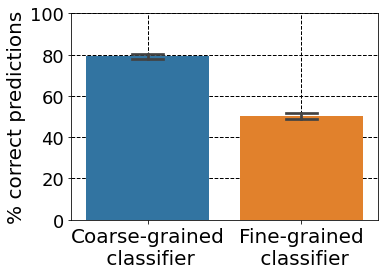

In [23]:
data = pd.DataFrame(columns=['algo','accuracy'])
data_list = list(zip(['Coarse-grained\n classifier']*len(accuracy_c), accuracy_c))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy']),ignore_index=True)

data_list = list(zip(['Fine-grained\n classifier']*len(accuracy_f), accuracy_f))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy']),ignore_index=True)

plt.figure(figsize=(5.5, 3.8))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)

ax = sns.barplot(x="algo", y="accuracy", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("% correct predictions")
# plt.title("Box plot of #candidates per cycle and system")

plt.ylim(0, 100)
plt.xticks(rotation=0)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

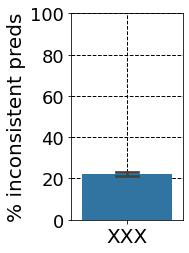

In [24]:
data = pd.DataFrame(columns=['algo','consistency'])

data_list = list(zip(['XXX']*len(consistency), consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','consistency']),ignore_index=True)

plt.figure(figsize=(2, 3.8))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
ax = sns.barplot(x="algo", y="consistency", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("% inconsistent preds")
# plt.title("Box plot of #candidates per cycle and system")

plt.ylim(0, 100)
plt.xticks(rotation=0)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

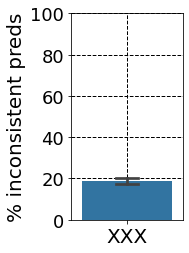

In [25]:
data = pd.DataFrame(columns=['algo','consistency2'])

data_list = list(zip(['XXX']*len(consistency2), consistency2))
data = data.append(pd.DataFrame(data_list, columns=['algo','consistency2']),ignore_index=True)

plt.figure(figsize=(2, 3.8))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
ax = sns.barplot(x="algo", y="consistency2", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("% inconsistent preds")
# plt.title("Box plot of #candidates per cycle and system")
plt.ylim(0, 100)
plt.xticks(rotation=0)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

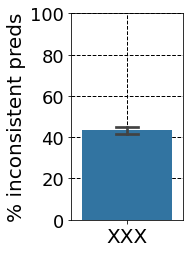

In [26]:
data = pd.DataFrame(columns=['algo','consistency3'])

data_list = list(zip(['XXX']*len(consistency3), consistency3))
data = data.append(pd.DataFrame(data_list, columns=['algo','consistency3']),ignore_index=True)

plt.figure(figsize=(2, 3.8))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
ax = sns.barplot(x="algo", y="consistency3", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("% inconsistent preds")
# plt.title("Box plot of #candidates per cycle and system")
plt.ylim(0, 100)
plt.xticks(rotation=0)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

Model: "Model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
out_c (Dense)                   (None, 9)            4617        flatten_5[0][0]                  
____________________________________________________________________________________________

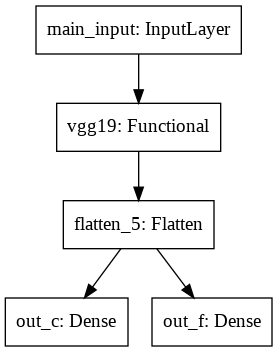

In [48]:
# Create the model
model1_pi0_5 = get_model1(pi=0.5)
model1_pi0_5.summary()
#train model
history_model11_pi0_5 = model1_pi0_5.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model1_pi0_5)


Model: "Model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_19 (Flatten)         (None, 512)               0         
_________________________________________________________________
out_c (Dense)                (None, 9)                 4617      
_________________________________________________________________
out_f (Dense)                (None, 100)               1000      
Total params: 20,030,001
Trainable params: 20,030,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
391/391 [==============================] - 17s 40ms/step - loss: 3.2254 - out_c_loss: 1.8466 - out_f_l

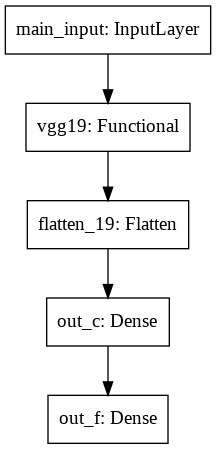

In [58]:
# Create the model
model2 = get_model2(pi=0.5)
model2.summary()
#train model
history_model2 = model2.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model2)


Model: "Model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_20 (Flatten)         (None, 512)               0         
_________________________________________________________________
out_f (Dense)                (None, 100)               51300     
_________________________________________________________________
out_c (Dense)                (None, 9)                 909       
Total params: 20,076,593
Trainable params: 20,076,593
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
391/391 [==============================] - 17s 40ms/step - loss: 3.7182 - out_c_loss: 2.1950 - out_f_l

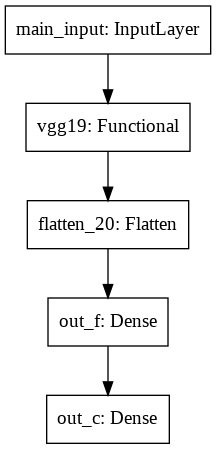

In [59]:
# Create the model
model3 = get_model3(pi=0.5)
model3.summary()
#train model
history_model3 = model3.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model3)


Model: "Model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_21 (Flatten)            (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
logits_c (Dense)                (None, 9)            4617        flatten_21[0][0]                 
____________________________________________________________________________________________

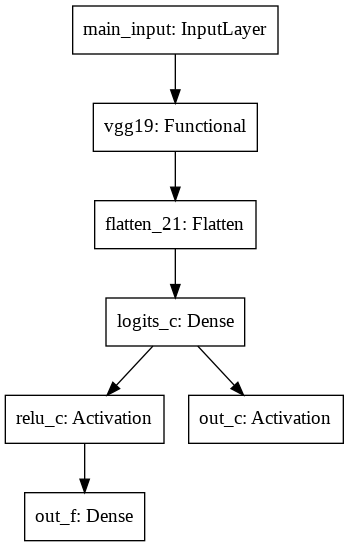

In [60]:
# Create the model
model4 = get_model4(pi=0.5)
model4.summary()
#train model
history_model4 = model4.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model4)


Model: "Model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_22 (Flatten)            (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
logits_f (Dense)                (None, 100)          51300       flatten_22[0][0]                 
____________________________________________________________________________________________

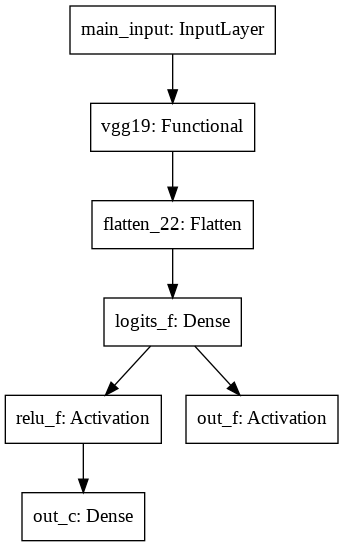

In [61]:
# Create the model
model5 = get_model5(pi=0.5)
model5.summary()
#train model
history_model5 = model5.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model5)


Model: "Model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19_1 (Functional)            (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
vgg19_2 (Functional)            (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 512)          0           vgg19_1[0][0]                    
____________________________________________________________________________________________

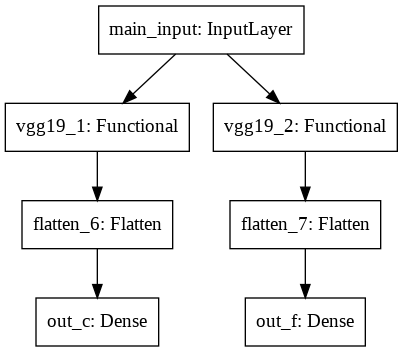

In [49]:
# Create the model
model6 = get_model6(pi=0.5)
model6.summary()
#train model
history_model6 = model6.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model6)



Model: "Model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_31 (Flatten)         (None, 512)               0         
_________________________________________________________________
custom__layer_12 (Custom_Lay ((None, 9), (None, 100))  55917     
Total params: 20,080,301
Trainable params: 20,080,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
391/391 [==============================] - 17s 41ms/step - loss: 2.4788 - custom__layer_12_loss: 2.1657 - custom__layer_12_1_loss: 5.2968 - custom__layer_12_accuracy: 0.2074 - custom__layer_12_1_accuracy: 0.0125 - val_loss: 2.1404 - v

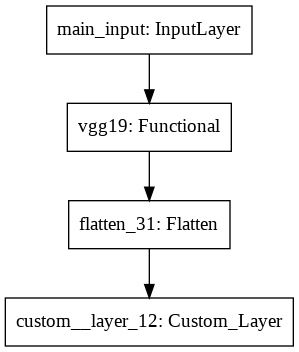

In [112]:
# Create the model
model7_pi_0_1 = get_model7(pi=0.1)
model7_pi_0_1.summary()
#train model
history_model7_pi_0_1 = model7_pi_0_1.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_pi_0_1)


Model: "Model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_32 (Flatten)         (None, 512)               0         
_________________________________________________________________
custom__layer_13 (Custom_Lay ((None, 9), (None, 100))  55917     
Total params: 20,080,301
Trainable params: 20,080,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
391/391 [==============================] - 17s 41ms/step - loss: 2.9099 - custom__layer_13_loss: 2.0465 - custom__layer_13_1_loss: 4.9244 - custom__layer_13_accuracy: 0.3179 - custom__layer_13_1_accuracy: 0.0185 - val_loss: 2.5638 - v

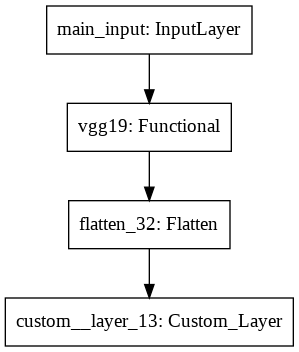

In [113]:
# Create the model
model7_pi_0_3 = get_model7(pi=0.3)
model7_pi_0_3.summary()
#train model
history_model7_pi_0_3 = model7_pi_0_3.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_pi_0_3)


Model: "Model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_33 (Flatten)         (None, 512)               0         
_________________________________________________________________
custom__layer_14 (Custom_Lay ((None, 9), (None, 100))  55917     
Total params: 20,080,301
Trainable params: 20,080,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
391/391 [==============================] - 18s 41ms/step - loss: 3.5667 - custom__layer_14_loss: 2.1307 - custom__layer_14_1_loss: 5.0027 - custom__layer_14_accuracy: 0.2917 - custom__layer_14_1_accuracy: 0.0182 - val_loss: 3.2230 - v

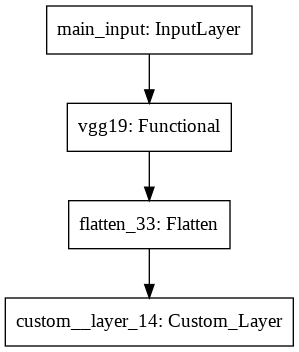

In [114]:
# Create the model
model7_pi_0_5 = get_model7(pi=0.5)
model7_pi_0_5.summary()
#train model
history_model7_pi_0_5 = model7_pi_0_5.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_pi_0_5)


Model: "Model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_34 (Flatten)         (None, 512)               0         
_________________________________________________________________
custom__layer_15 (Custom_Lay ((None, 9), (None, 100))  55917     
Total params: 20,080,301
Trainable params: 20,080,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
391/391 [==============================] - 17s 41ms/step - loss: 4.1251 - custom__layer_15_loss: 2.2121 - custom__layer_15_1_loss: 4.9450 - custom__layer_15_accuracy: 0.2600 - custom__layer_15_1_accuracy: 0.0132 - val_loss: 3.7782 - v

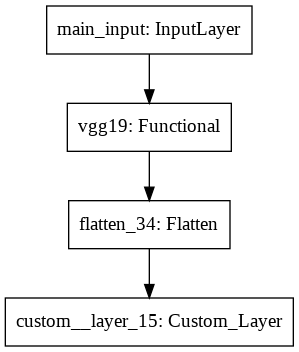

In [115]:
# Create the model
model7_pi_0_7 = get_model7(pi=0.7)
model7_pi_0_7.summary()
#train model
history_model7_pi_0_7 = model7_pi_0_7.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_pi_0_7)


Model: "Model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_35 (Flatten)         (None, 512)               0         
_________________________________________________________________
custom__layer_16 (Custom_Lay ((None, 9), (None, 100))  55917     
Total params: 20,080,301
Trainable params: 20,080,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
391/391 [==============================] - 17s 41ms/step - loss: 4.7117 - custom__layer_16_loss: 2.3940 - custom__layer_16_1_loss: 4.9693 - custom__layer_16_accuracy: 0.1592 - custom__layer_16_1_accuracy: 0.0215 - val_loss: 4.2853 - v

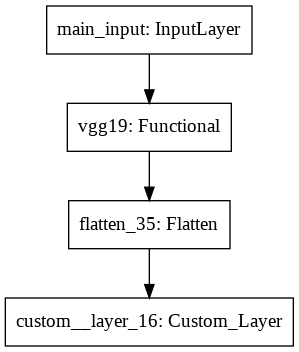

In [116]:
# Create the model
model7_pi_0_9 = get_model7(pi=0.9)
model7_pi_0_9.summary()
#train model
history_model7_pi_0_9 = model7_pi_0_9.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_pi_0_9)


Model: "Model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_36 (Flatten)         (None, 512)               0         
_________________________________________________________________
custom__layer_17 (Custom_Lay ((None, 9), (None, 100))  55917     
Total params: 20,080,301
Trainable params: 20,080,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
391/391 [==============================] - 17s 41ms/step - loss: 2.0865 - custom__layer_17_loss: 1.7531 - custom__layer_17_1_loss: 5.0871 - custom__layer_17_accuracy: 0.4853 - custom__layer_17_1_accuracy: 0.0371 - val_loss: 1.4612 - v

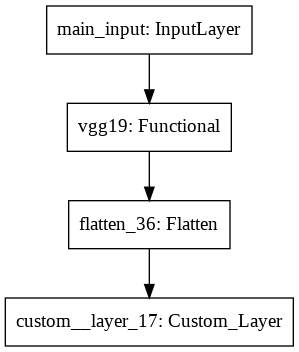

In [125]:
# Create the model
model7_c_to_f_pi_0_1 = get_model7(pi=0.1, mode='c_to_f')
model7_c_to_f_pi_0_1.summary()
#train model
history_model7_c_to_f_pi_0_1 = model7_c_to_f_pi_0_1.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_c_to_f_pi_0_1)


Model: "Model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_38 (Flatten)         (None, 512)               0         
_________________________________________________________________
custom__layer_19 (Custom_Lay ((None, 9), (None, 100))  55917     
Total params: 20,080,301
Trainable params: 20,080,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
391/391 [==============================] - 17s 41ms/step - loss: 2.8295 - custom__layer_19_loss: 1.9521 - custom__layer_19_1_loss: 4.8768 - custom__layer_19_accuracy: 0.4392 - custom__layer_19_1_accuracy: 0.0353 - val_loss: 2.1824 - v

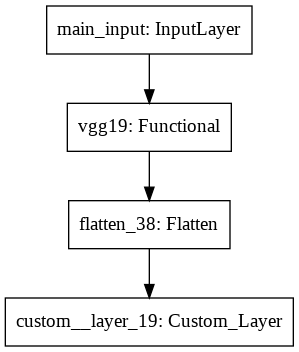

In [127]:
# Create the model
model7_c_to_f_pi_0_3 = get_model7(pi=0.3, mode='c_to_f')
model7_c_to_f_pi_0_3.summary()
#train model
history_model7_c_to_f_pi_0_3 = model7_c_to_f_pi_0_3.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_c_to_f_pi_0_3)


Model: "Model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_39 (Flatten)         (None, 512)               0         
_________________________________________________________________
custom__layer_20 (Custom_Lay ((None, 9), (None, 100))  55917     
Total params: 20,080,301
Trainable params: 20,080,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
391/391 [==============================] - 17s 40ms/step - loss: 3.4792 - custom__layer_20_loss: 2.0951 - custom__layer_20_1_loss: 4.8633 - custom__layer_20_accuracy: 0.3900 - custom__layer_20_1_accuracy: 0.0350 - val_loss: 2.8634 - v

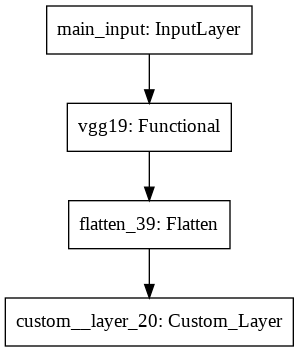

In [128]:
# Create the model
model7_c_to_f_pi_0_5 = get_model7(pi=0.5, mode='c_to_f')
model7_c_to_f_pi_0_5.summary()
#train model
history_model7_c_to_f_pi_0_5 = model7_c_to_f_pi_0_5.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_c_to_f_pi_0_5)


Model: "Model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_40 (Flatten)         (None, 512)               0         
_________________________________________________________________
custom__layer_21 (Custom_Lay ((None, 9), (None, 100))  55917     
Total params: 20,080,301
Trainable params: 20,080,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
391/391 [==============================] - 17s 40ms/step - loss: 4.1673 - custom__layer_21_loss: 2.5280 - custom__layer_21_1_loss: 4.8699 - custom__layer_21_accuracy: 0.2773 - custom__layer_21_1_accuracy: 0.0224 - val_loss: 3.6844 - v

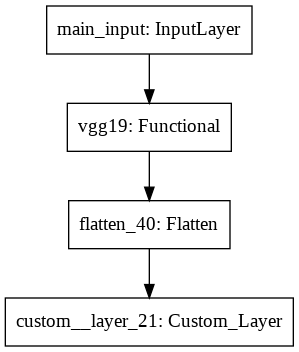

In [129]:
# Create the model
model7_c_to_f_pi_0_7 = get_model7(pi=0.7, mode='c_to_f')
model7_c_to_f_pi_0_7.summary()
#train model
history_model7_c_to_f_pi_0_7 = model7_c_to_f_pi_0_7.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_c_to_f_pi_0_7)


Model: "Model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_41 (Flatten)         (None, 512)               0         
_________________________________________________________________
custom__layer_22 (Custom_Lay ((None, 9), (None, 100))  55917     
Total params: 20,080,301
Trainable params: 20,080,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
391/391 [==============================] - 17s 40ms/step - loss: 4.7552 - custom__layer_22_loss: 2.7775 - custom__layer_22_1_loss: 4.9750 - custom__layer_22_accuracy: 0.2264 - custom__layer_22_1_accuracy: 0.0251 - val_loss: 4.2390 - v

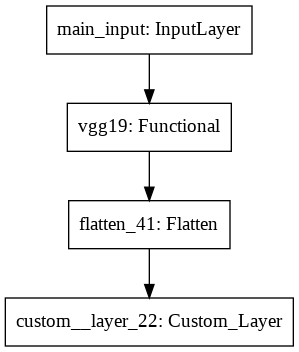

In [130]:
# Create the model
model7_c_to_f_pi_0_9 = get_model7(pi=0.9, mode='c_to_f')
model7_c_to_f_pi_0_9.summary()
#train model
history_model7_c_to_f_pi_0_9 = model7_c_to_f_pi_0_9.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_c_to_f_pi_0_9)


Model: "Model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_42 (Flatten)         (None, 512)               0         
_________________________________________________________________
custom__layer_23 (Custom_Lay ((None, 9), (None, 100))  55917     
Total params: 20,080,301
Trainable params: 20,080,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
391/391 [==============================] - 17s 40ms/step - loss: 2.4809 - custom__layer_23_loss: 2.0727 - custom__layer_23_1_loss: 6.1548 - custom__layer_23_accuracy: 0.3086 - custom__layer_23_1_accuracy: 0.0143 - val_loss: 2.1017 - v

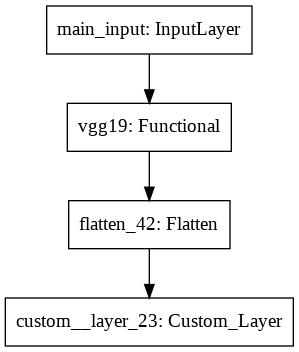

In [131]:
# Create the model
model7_f_to_c_pi_0_1 = get_model7(pi=0.1, mode='f_to_c')
model7_f_to_c_pi_0_1.summary()
#train model
history_model7_f_to_c_pi_0_1 = model7_f_to_c_pi_0_1.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_f_to_c_pi_0_1)


Model: "Model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_43 (Flatten)         (None, 512)               0         
_________________________________________________________________
custom__layer_24 (Custom_Lay ((None, 9), (None, 100))  55917     
Total params: 20,080,301
Trainable params: 20,080,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
391/391 [==============================] - 17s 40ms/step - loss: 3.1487 - custom__layer_24_loss: 2.1460 - custom__layer_24_1_loss: 5.4884 - custom__layer_24_accuracy: 0.2867 - custom__layer_24_1_accuracy: 0.0184 - val_loss: 2.7645 - v

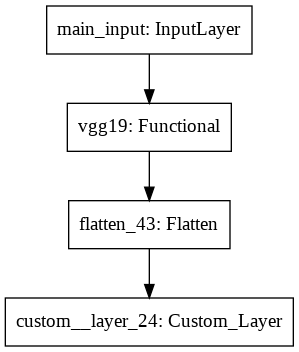

In [132]:
# Create the model
model7_f_to_c_pi_0_3 = get_model7(pi=0.3, mode='f_to_c')
model7_f_to_c_pi_0_3.summary()
#train model
history_model7_f_to_c_pi_0_3 = model7_f_to_c_pi_0_3.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_f_to_c_pi_0_3)


Model: "Model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_44 (Flatten)         (None, 512)               0         
_________________________________________________________________
custom__layer_25 (Custom_Lay ((None, 9), (None, 100))  55917     
Total params: 20,080,301
Trainable params: 20,080,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
391/391 [==============================] - 17s 40ms/step - loss: 3.7150 - custom__layer_25_loss: 2.1899 - custom__layer_25_1_loss: 5.2401 - custom__layer_25_accuracy: 0.2883 - custom__layer_25_1_accuracy: 0.0183 - val_loss: 3.2729 - v

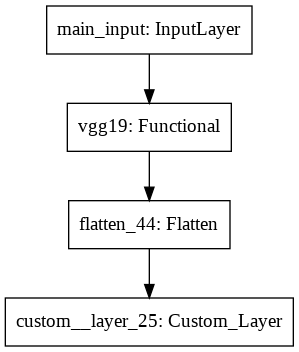

In [133]:
# Create the model
model7_f_to_c_pi_0_5 = get_model7(pi=0.5, mode='f_to_c')
model7_f_to_c_pi_0_5.summary()
#train model
history_model7_f_to_c_pi_0_5 = model7_f_to_c_pi_0_5.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_f_to_c_pi_0_5)

Model: "Model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_45 (Flatten)         (None, 512)               0         
_________________________________________________________________
custom__layer_26 (Custom_Lay ((None, 9), (None, 100))  55917     
Total params: 20,080,301
Trainable params: 20,080,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
391/391 [==============================] - 17s 40ms/step - loss: 4.2453 - custom__layer_26_loss: 2.2108 - custom__layer_26_1_loss: 5.1173 - custom__layer_26_accuracy: 0.2896 - custom__layer_26_1_accuracy: 0.0272 - val_loss: 3.7402 - v

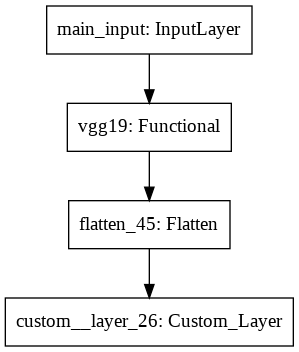

In [134]:
# Create the model
model7_f_to_c_pi_0_7 = get_model7(pi=0.7, mode='f_to_c')
model7_f_to_c_pi_0_7.summary()
#train model
history_model7_f_to_c_pi_0_7 = model7_f_to_c_pi_0_7.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_f_to_c_pi_0_7)


Model: "Model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_46 (Flatten)         (None, 512)               0         
_________________________________________________________________
custom__layer_27 (Custom_Lay ((None, 9), (None, 100))  55917     
Total params: 20,080,301
Trainable params: 20,080,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
391/391 [==============================] - 17s 40ms/step - loss: 4.8843 - custom__layer_27_loss: 2.2810 - custom__layer_27_1_loss: 5.1735 - custom__layer_27_accuracy: 0.2458 - custom__layer_27_1_accuracy: 0.0196 - val_loss: 4.2483 - v

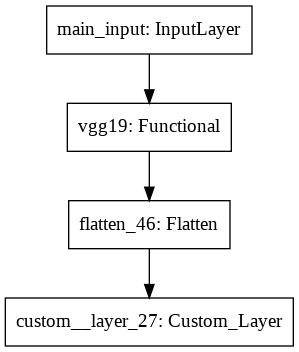

In [135]:
# Create the model
model7_f_to_c_pi_0_9 = get_model7(pi=0.9, mode='f_to_c')
model7_f_to_c_pi_0_9.summary()
#train model
history_model7_f_to_c_pi_0_9 = model7_f_to_c_pi_0_9.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_f_to_c_pi_0_9)


Model: "Model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19_1 (Functional)            (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
vgg19_2 (Functional)            (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_11 (Flatten)            (None, 512)          0           vgg19_1[0][0]                    
____________________________________________________________________________________________

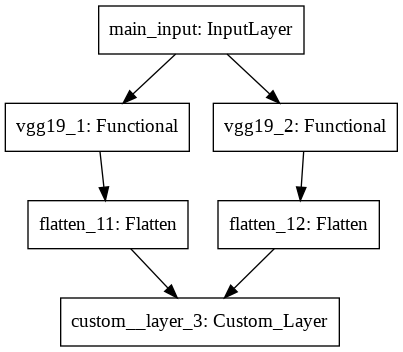

In [53]:
# # # Create the model
model8 = get_model8(pi=0.5)
model8.summary()
plot_model(model8)
#train model
history_model8 = model8.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model8)



Model: "Model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19_1 (Functional)            (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
vgg19_2 (Functional)            (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_13 (Flatten)            (None, 512)          0           vgg19_1[0][0]                    
____________________________________________________________________________________________

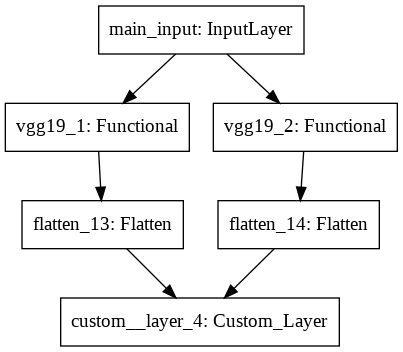

In [54]:
# # # Create the model
model8_c_to_f = get_model8(pi=0.5, mode='c_to_f')
model8_c_to_f.summary()
plot_model(model8_c_to_f)
#train model
history_model8_c_to_f = model8_c_to_f.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model8_c_to_f)



Model: "Model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19_1 (Functional)            (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
vgg19_2 (Functional)            (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_15 (Flatten)            (None, 512)          0           vgg19_1[0][0]                    
____________________________________________________________________________________________

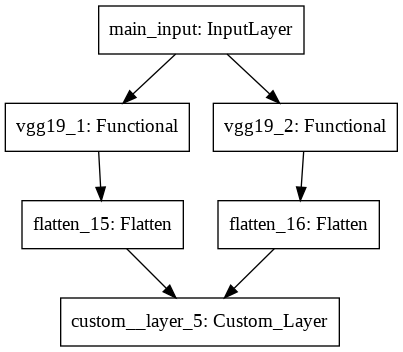

In [55]:
# # # Create the model
model8_f_to_c = get_model8(pi=0.5, mode='f_to_c')
model8_f_to_c.summary()
plot_model(model8_f_to_c)
#train model
history_model8_f_to_c = model8_f_to_c.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model8_f_to_c)



In [138]:
data = pd.DataFrame(columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency'])

# accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model1_pi1, X_test, y_test)
# data_list = list(zip(['model1_pi1']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
# data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

# accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model1_pi0, X_test, y_test)
# data_list = list(zip(['model1_pi0']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
# data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model1_pi0_5, X_test, y_test)
data_list = list(zip(['model1_pi0.5']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

# accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model2, X_test, y_test)
# data_list = list(zip(['model2']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
# data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

# accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model3, X_test, y_test)
# data_list = list(zip(['model3']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
# data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

# accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model4, X_test, y_test)
# data_list = list(zip(['model4']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
# data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model5, X_test, y_test)
data_list = list(zip(['model5']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model6, X_test, y_test)
data_list = list(zip(['model6']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)


accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_pi_0_1, X_test, y_test)
data_list = list(zip(['model7_pi_0_1']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_pi_0_3, X_test, y_test)
data_list = list(zip(['model7_pi_0_3']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_pi_0_5, X_test, y_test)
data_list = list(zip(['model7_pi_0_5']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_pi_0_7, X_test, y_test)
data_list = list(zip(['model7_pi_0_7']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_pi_0_9, X_test, y_test)
data_list = list(zip(['model7_pi_0_9']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_c_to_f_pi_0_1, X_test, y_test)
data_list = list(zip(['model7_c_to_f_pi_0_1']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_c_to_f_pi_0_3, X_test, y_test)
data_list = list(zip(['model7_c_to_f_pi_0_3']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_c_to_f_pi_0_5, X_test, y_test)
data_list = list(zip(['model7_c_to_f_pi_0_5']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_c_to_f_pi_0_7, X_test, y_test)
data_list = list(zip(['model7_c_to_f_pi_0_7']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_c_to_f_pi_0_9, X_test, y_test)
data_list = list(zip(['model7_c_to_f_pi_0_9']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_f_to_c_pi_0_1, X_test, y_test)
data_list = list(zip(['model7_f_to_c_pi_0_1']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_f_to_c_pi_0_3, X_test, y_test)
data_list = list(zip(['model7_f_to_c_pi_0_3']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_f_to_c_pi_0_5, X_test, y_test)
data_list = list(zip(['model7_f_to_c_pi_0_5']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_f_to_c_pi_0_7, X_test, y_test)
data_list = list(zip(['model7_f_to_c_pi_0_7']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_f_to_c_pi_0_9, X_test, y_test)
data_list = list(zip(['model7_f_to_c_pi_0_9']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)





accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model8, X_test, y_test)
data_list = list(zip(['model8']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model8_c_to_f, X_test, y_test)
data_list = list(zip(['model8_c_to_f']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model8_f_to_c, X_test, y_test)
data_list = list(zip(['model8_f_to_c']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)


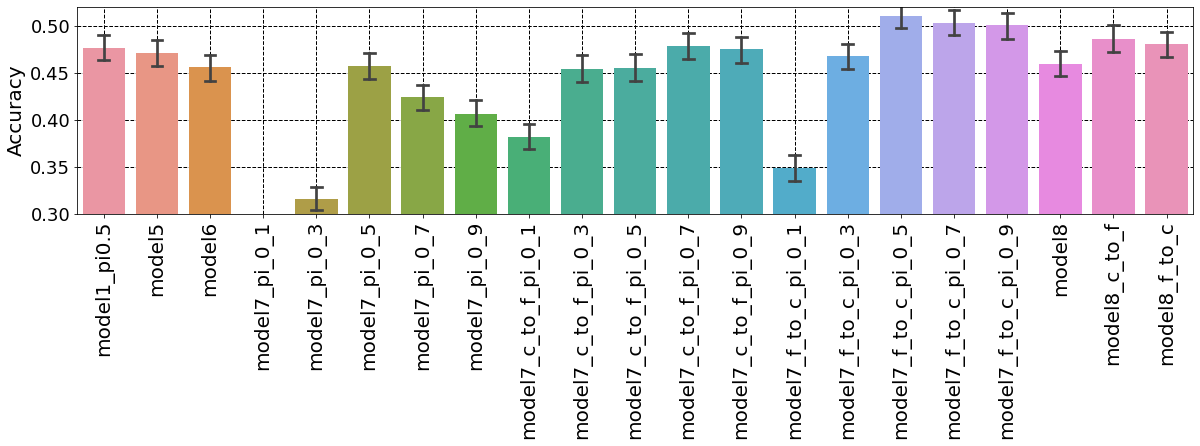

In [139]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(20, 3.8))

ax = sns.barplot(x="algo", y="accuracy", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("Accuracy")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.3, 0.52)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

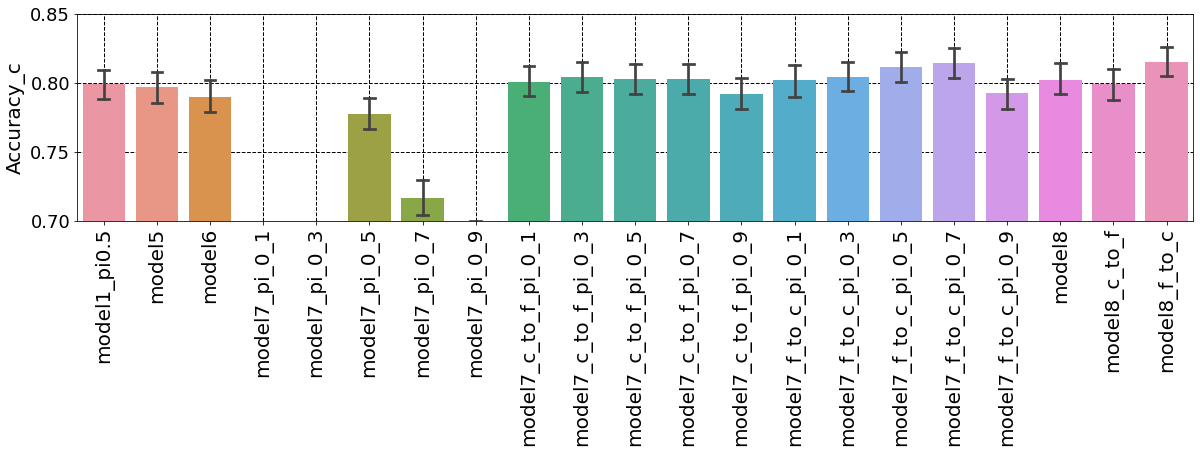

In [140]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(20, 3.8))

ax = sns.barplot(x="algo", y="accuracy_c", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("Accuracy_c")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.7, 0.85)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

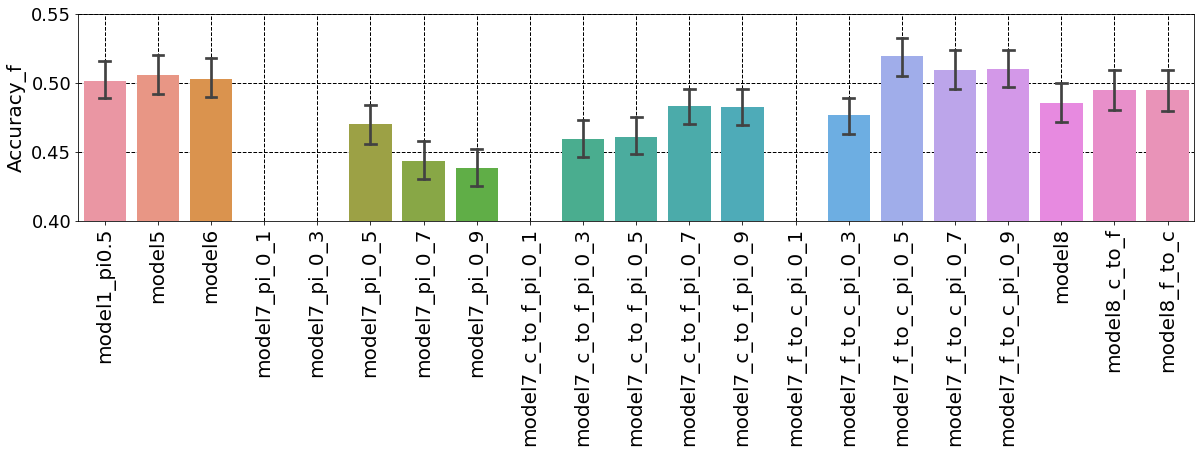

In [141]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(20, 3.8))

ax = sns.barplot(x="algo", y="accuracy_f", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("Accuracy_f")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.4, 0.55)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

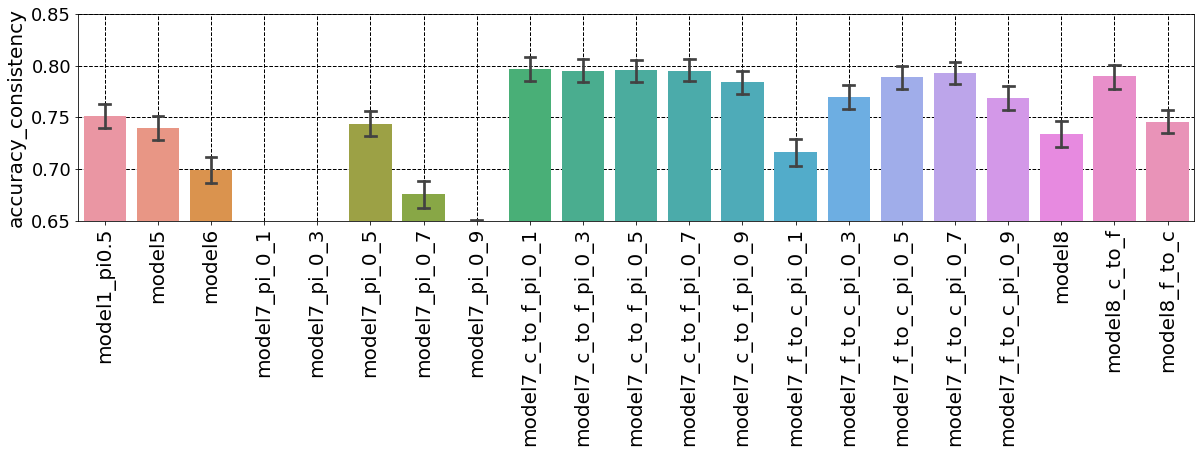

In [142]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(20, 3.8))

ax = sns.barplot(x="algo", y="accuracy_consistency", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("accuracy_consistency")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.65, 0.85)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

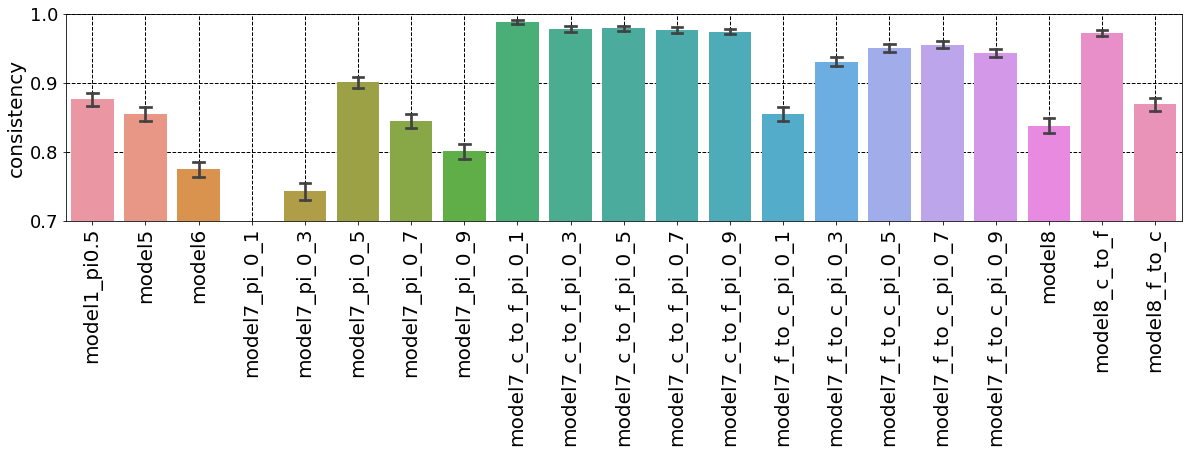

In [145]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(20, 3.8))

ax = sns.barplot(x="algo", y="consistency", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.7, 1.)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()


In [ ]:
out_f_accuracy = history.history['out_f_accuracy']
out_c_accuracy = history.history['out_c_accuracy']
val_out_f_accuracy = history.history['val_out_f_accuracy']
val_out_c_accuracy = history.history['val_out_c_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(15,4))

ax1 = plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.fill_between(epochs, loss,val_loss,color='g',alpha=.1)

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

ax2 = plt.subplot(1, 2, 2)
plt.plot(epochs, out_f_accuracy, label='Training f accuracy')
plt.plot(epochs, out_c_accuracy, label='Training c accuracy')
plt.plot(epochs, val_out_f_accuracy, label='Validation f accuracy')
plt.plot(epochs, val_out_c_accuracy, label='Validation c accuracy')
# plt.fill_between(epochs, acc,val_acc,color='g',alpha=.1)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
def nin(input_shape):
    # Define Network in Network model
    input = Input(shape=input_shape)
    x = Conv2D(filters=192, kernel_size=(5,5), activation='relu')(input)
    x = Conv2D(filters=160, kernel_size=(1,1), activation='relu')(x)
    x = Conv2D(filters=96, kernel_size=(1,1), activation='relu')(x)
    x = MaxPool2D(2, strides=2, padding='same')(x)
    x = Dropout(0.5)(x)

    x = Conv2D(filters=192, kernel_size=(5,5), activation='relu')(x)
    x = Conv2D(filters=192, kernel_size=(1,1), activation='relu')(x)
    x = Conv2D(filters=192, kernel_size=(1,1), activation='relu')(x)
    x = MaxPool2D(2, strides=2, padding='same')(x)
    x = Dropout(0.5)(x)

    x = Conv2D(filters=192, kernel_size=(3,3), activation='relu')(x)
    x = Conv2D(filters=192, kernel_size=(1,1), activation='relu')(x)
    x = Conv2D(filters=10, kernel_size=(1,1), activation='relu')(x)

    output = GlobalAveragePooling2D()(x)

    model = Model(input, output)

    return model 


    
model = nin(input_shape=(28,28,1))

model.summary()


In [ ]:
conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")
type(model)